In [45]:
#Load the Libraries
import torch
import matplotlib.pyplot as plt
from  torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
transform = transforms.ToTensor()

In [48]:
#Load the CIFAR-10 training data
train_dataset= datasets.CIFAR10(root='./data',
                                train=True,
                                download=True,
                                transform=transform)

test_dataset= datasets.CIFAR10(root='./data',
                                train=False,
                                download=True,
                                transform=transform)

train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=16,shuffle=True)


/home/section/Desktop/Files/MTECH IIT/Git projects/Projects/genai-vae-assignment/.venv/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


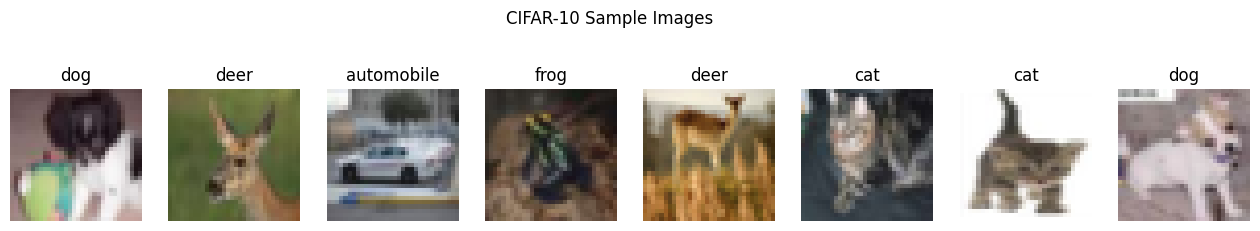

In [6]:
# Class names
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Get one batch of images
images, labels = next(iter(train_loader))

#Plot the samples

fig,axes=plt.subplots(1,8,figsize =(16,3))

for i,ax in enumerate(axes):
    img=images[i].permute(1,2,0) # (C,H,W) -> (H,W,C)
    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])
    ax.axis("off")

plt.suptitle("CIFAR-10 Sample Images")
plt.show()

## Task 1: Architectural Design


In [31]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=4,stride=2,padding=1),  # (B, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=4,stride=2,padding=1), # (B, 64, 8, 8)
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1), # (B, 128, 4, 4)
            nn.ReLU()
        )

        self.fc=nn.Linear(128*4*4,2*latent_dim)

    def forward(self,x):
        h=self.conv(x)
        h=h.view(h.size(0),-1)
        mean,logvar = torch.chunk(self.fc(h), 2, dim=1)

        return mean, logvar
        

In [43]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc=nn.Linear(latent_dim,128*4*4)
        self.deconv=nn.Sequential(
            # (B, 128, 4, 4) → (B, 64, 8, 8)
            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
            nn.ReLU(),

            # (B, 64, 8, 8) → (B, 32, 16, 16)
            nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
            nn.ReLU(),

            # (B, 32, 16, 16) → (B, 3, 32, 32)
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            
            )
            

       
    def forward(self,z):
        x=self.fc(z)
        x=x.view(-1,128,4,4)
        x=self.deconv(x)
        
        return torch.sigmoid(x)

### Generate encoder and decoder summary

In [41]:
latent_dimension=128
encoder=Encoder(latent_dimension)

summary(encoder,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,568
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          32,832
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]         131,200
              ReLU-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
Total params: 690,144
Trainable params: 690,144
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.22
Params size (MB): 2.63
Estimated Total Size (MB): 2.87
----------------------------------------------------------------


In [44]:
decoder=Decoder(latent_dimension)

summary(decoder,input_size=(latent_dimension,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]         264,192
   ConvTranspose2d-2             [-1, 64, 8, 8]         131,136
              ReLU-3             [-1, 64, 8, 8]               0
   ConvTranspose2d-4           [-1, 32, 16, 16]          32,800
              ReLU-5           [-1, 32, 16, 16]               0
   ConvTranspose2d-6            [-1, 3, 32, 32]           1,539
Total params: 429,667
Trainable params: 429,667
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 1.64
Estimated Total Size (MB): 1.87
----------------------------------------------------------------


# Task 2: Training and Performance

In [71]:
def log_norm_pdf(sample,mean,logvar,dim=1):
    log2pi=math.log(2.*math.pi)
    return torch.sum(
        -0.5*((sample-mean)**2*torch.exp(-logvar)+logvar+log2pi),dim=1
    )

def elbo_computation(encoder,decoder,x):

    #Encode

    mean,logvar=encoder(x)


    #Reparametrization trick
    eps = torch.rand_like(mean)
    z = mean+eps*torch.exp(0.5*logvar)

    #decode
    x_logits = decoder(z)  # (B, 3, 32, 32)

    #Reconstruction Term
    recon_loss=F.binary_cross_entropy_with_logits(x_logits,x,reduction='none')

    logpx_z=-torch.sum(recon_loss,dim=[1,2,3])

    # KL divergence terms

    logpz=log_norm_pdf(z, torch.zeros_like(z), torch.zeros_like(z))
    logqz_x=log_norm_pdf(z, mean, logvar)

    #Negative ELBO (for minimization)

    return -torch.mean(logpx_z + logpz - logqz_x)



In [72]:
def reset_metrics():
    return 0.0, 0

def update_metric(total_loss, count, loss, batch_size):
    return total_loss + loss.item() * batch_size, count + batch_size

def train_step(encoder,decoder,images,optimizer):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    loss=elbo_computation(encoder,decoder,images)
    loss.backward()
    optimizer.step()

    return loss.item()

def generate_and_display_images(decoder,noise):
    decoder.eval()

    with torch.no_grad():
        images= decoder(noise)

        images=images.cpu()
        fig = plt.figure(figsize=(16, 2))
        for i in range(images.size(0)):
            plt.subplot(1, 8, i + 1)
            img = images[i].permute(1, 2, 0)  # (C,H,W) → (H,W,C)
            plt.imshow(img)
            plt.axis("off")

        plt.show()

def plot_training_curves(train_elbo,test_elbo):
    epochs = range(1, len(train_elbo) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_elbo, label="Training ELBO")
    plt.plot(epochs, test_elbo, label="Test ELBO")

    plt.xlabel("Epoch")
    plt.ylabel("ELBO")
    plt.title("VAE Training Curves")
    plt.legend()
    plt.grid(True)
    plt.show()



In [73]:
def train_the_vae(encoder,decoder,train_loader,test_loader,optimizer,epochs,latent_dim,device):

    train_elbo_history = []
    test_elbo_history = []
    
    noise=torch.randn(8,latent_dim).to(device)

    generate_and_display_images(decoder,noise)

    for epoch in range(epochs):
        train_loss_sum,train_count=reset_metrics()
        test_loss_sum,test_count=reset_metrics()


    #Train
    for images,_ in train_loader:
        images=images.to(device)
        loss=train_step(encoder,decoder,images,optimizer)
        train_loss_sum,train_count=update_metric(test_loss_sum,
                                                 train_count,torch.tensor(loss),
                                                 images.size(0))
        
    #Test
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for images,_ in test_loader:
            images=images.to(device)
            loss= elbo_computation(encoder,decoder,images)
            test_loss_sum,test_count=update_metric(
                test_loss_sum,test_count,loss,images.size(0)
            )

    train_elbo=train_loss_sum/train_count
    test_elbo=test_loss_sum/test_elbo
    train_elbo_history.append(-train_elbo)  # negative ELBO = actual ELBO
    test_elbo_history.append(-test_elbo)

    print(
        f"Epoch {epoch+1:03d}:",
        f"Train ELBO {-train_elbo:.3f}",
        f"Test ELBO {-test_elbo:.3f}"
    )

    noise=torch.randn(8,latent_dim).to(device)
    generate_and_display_images(decoder,noise)
    

In [74]:
latent_dimension=128
learning_rate =1e-4
epochs =20
encoder=Encoder(latent_dimension).to(device)
decoder=Decoder(latent_dimension).to(device)

optimizer= torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()),lr=learning_rate)

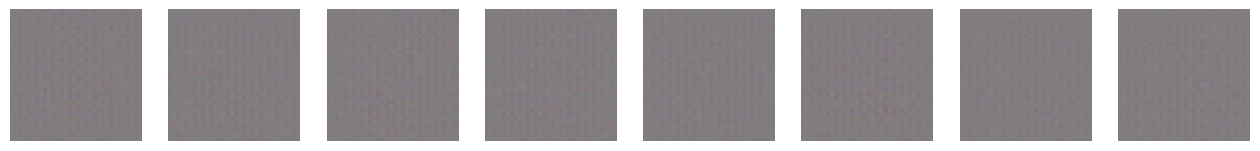

KeyboardInterrupt: 

In [75]:
train_the_vae(encoder,decoder,train_loader,test_loader,optimizer,epochs,latent_dimension,device)